In [1]:
import sys
sys.path.insert(0, "../")

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import flax.linen as nn
from matplotlib import pyplot as plt
import module.util as util

## Score Matching
### The Score Function
Score Matchinig is an integral part of diffusion modelling. In order to represent a probability distribution $p(x)$ for $x \in \Chi$ one can compute its score-function $s$:
$$
s(x) = \nabla \log p(x)
$$
On the other hand, if $s$ satisfies integrability conditions, it unikely characterises the probability distribution $p(x)$, as the integration constant is found via requiring that $p(x)$ is normalised.

### Fitting the Score Function
If one is presented a distribution of data, which we would like to model, it often comes represented by samples $x_i \in D$. Score-Matching tries to obtain the underlying distribution implicitly, by learning the score-function $s$. To do this, we minimise the $L^2$ norm of $s(x) - \nabla \log p(x)$ on the measure-space $(\Chi, \mathcal{B}(\Chi), p\, d\mu)$. Written out, this is:
$$
L[s] = \int_\Chi || s(x) - \nabla \log p(x) ||^2  p(x) d\mu
$$
### Numerics
As the loss-functional $L$ involes (i) and integral over $\Chi$ and (ii) inacessible gradients of $p$, we will make use of partial integration and sampling:
$$
\begin{align}
\argmin_s L[s] &= \argmin_s \int_\Chi || s(x) - \nabla \log p(x) ||^2  p(x) d\mu \\
 &=  \argmin_s \int_\Chi \left[|| s(x) || ^2  - 2 s(x) \cdot \nabla \log p(x)\right]  p(x) d\mu \\
 &= \argmin_s \int_\Chi p(x) d\mu \left[ ||s(x)||^2 +2 tr(J s(x)) \right] \\
 &= \argmin_s \lim_{N\to\infty} \frac{1}{N}\sum_{x_i \sim p(x)}^N ||s(x_i)||^2 +2 tr(J s(x_i))
\end{align}
$$

As the trace of the Jacobian of the score (or for energy based models, the laplacian of the negative energy) is costly to compute, we will use the Hutchinson trace estimator
$$
tr A = \mathbb{E}\left[ \omega^T A \omega \right]
$$
where $\mathbb{E}\left[ \omega\right] = 0$ and $\mathbb{E}\left[\omega \omega^T\right] = \underline{1}$.

The above expectation is then expanded to not just sample $x \sim p(x)$ but to sample, $x, \omega \sim p(x)\mathcal{N}(\omega)$ independantly. $\mathcal{N}$ is a standard gaussian. The Loss function then reduces to
$$
\begin{align}
\argmin_s L[s] &= \argmin_s \lim_{N \to \infty} \frac{1}{N}\sum_{x_i \sim p(x)}^N ||s(x_i)||^2 +2 tr(J s(x_i))\\
            &= \argmin_s \lim_{N \to \infty} \frac{1}{N}\sum_{x_i, \,\omega_i}^N ||s(x_i)||^2 +2 w_i^T J s(x_i) w_i
\end{align}
$$

## Example
In the following we will try to match the score function of a simple example distribution.
### Toy Distribution

In [2]:
key = jax.random.PRNGKey(0)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
space_dim = 2

def get_samples(key, N = 1000):
    swap = jax.random.choice(key, jnp.array([-1.,1.]), (N,))
    key, _ = jax.random.split(key)
    x1 = jax.random.normal(key, (N,))*0.2 + swap*0.9
    key, _ = jax.random.split(key)
    x2 = jax.random.normal(key, (N,))*0.2

    return jnp.stack((x1, x2), axis = -1)

def calc_log_p(input):
    x = input[...,0]
    y = input[...,1]
    a = stats.norm.pdf(x, loc = -0.9, scale = 0.2)
    b = stats.norm.pdf(x, loc = 0.9, scale = 0.2)
    c = stats.norm.pdf(y, loc = 0, scale = 0.2)
    return jnp.log(0.5*(a+b)*c)

def calc_score(x):
    score = jax.vjp(calc_log_p, x)[1](jnp.ones(x.shape[0:-1]))[0]
    return score

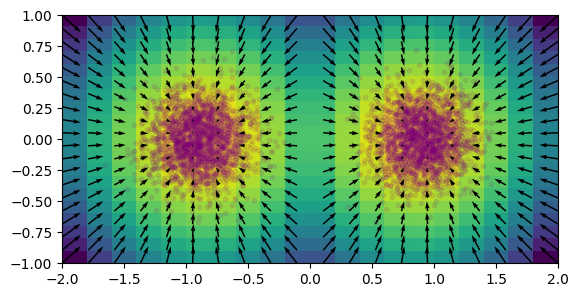

In [4]:
key, _ = jax.random.split(key)
samples = get_samples(key, 5000)

xs = jnp.linspace(-2, 2, num = 20)
ys = jnp.linspace(-1, 1, num = 20)
xx, yy = jnp.meshgrid(xs, ys)
coord = jnp.stack((xx, yy), axis = -1)

log_p = calc_log_p(coord)
score = calc_score(coord)

plt.scatter(samples[:,0], samples[:,1], color = "purple", alpha = 0.1, marker = ".")
plt.imshow(log_p, extent = [-2, 2, -1, 1])
plt.quiver(xx, yy, score[...,0],score[...,1])

### Define Score Model

In [5]:
act = lambda x: jnp.log(jnp.cosh(x))

class ScoreModel(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(32, bias_init=nn.initializers.normal())(x)
    x = act(x)
    x = nn.Dense(32, bias_init=nn.initializers.normal())(x)
    x = act(x)
    x = nn.Dense(space_dim, bias_init=nn.initializers.normal())(x)
    return x

### Optimisation

In [6]:
model = ScoreModel()
param = model.init(key, jnp.empty((space_dim,)))

In [7]:
@jax.jit
def calc_loss(param, samples, w):
    eval = model.apply(param, samples)
    score = calc_score(samples)

    a = jnp.sum(eval ** 2, axis = -1)
    b = jnp.sum(score ** 2, axis = -1)
    c = 2*jnp.sum(w*jax.jvp(model.apply, (param, samples), (util.t_zeros_like(param), w))[1], axis = -1)

    return jnp.mean(a+b+c)

@jax.jit
def grad_loss(param, samples, w):
    l = lambda param: calc_loss(param, samples, w)
    grad = jax.vjp(l, param)[1](jnp.array(1.))
    return grad[0]

In [8]:
losses = []

In [11]:
N = 3000
lr = 0.001
for i in range(900):
    key, _ = jax.random.split(key)
    samples = get_samples(key, N)
    key, _ = jax.random.split(key)
    w = jax.random.normal(key, (N, space_dim))

    loss = calc_loss(param, samples, w)
    losses.append(loss)

    grad = grad_loss(param, samples, w)

    param = util.t_sum(param, util.s_mul(-lr, grad))

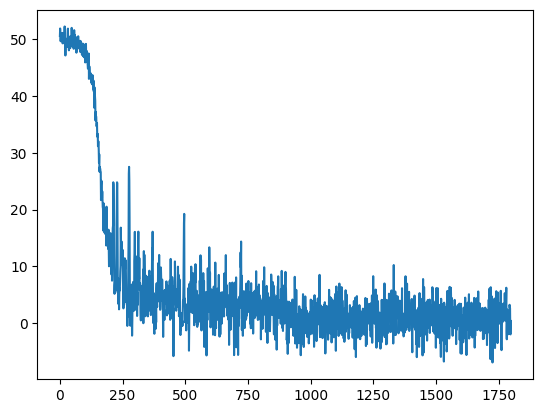

In [12]:
plt.plot(losses)

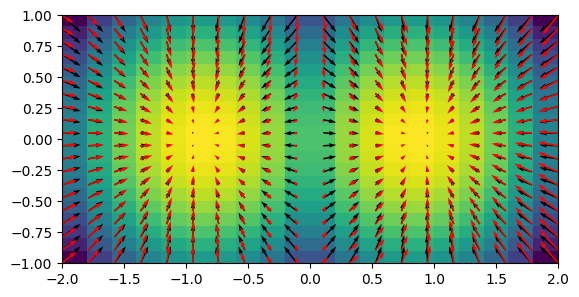

In [13]:
key, _ = jax.random.split(key)
samples = get_samples(key, 5000)

xs = jnp.linspace(-2, 2, num = 20)
ys = jnp.linspace(-1, 1, num = 20)
xx, yy = jnp.meshgrid(xs, ys)
coord = jnp.stack((xx, yy), axis = -1)

log_p = calc_log_p(coord)
score = calc_score(coord)
score_approx = model.apply(param, coord)

# plt.scatter(samples[:,0], samples[:,1], color = "purple", alpha = 0.1, marker = ".")
plt.imshow(log_p, extent = [-2, 2, -1, 1])
plt.quiver(xx, yy, score[...,0],score[...,1])
plt.quiver(xx, yy, score_approx[...,0], score_approx[...,1], color = "r")

## Sample using the Score-Function
After obtaining the score function, multiple methods are available for generating samples of the underlying distribution. Here, we just use a simple Langevin dynamics which converges to the Boltzmann-distribution:
$$
dx = \nabla \log p\,dt + \sqrt{2}\,dW
$$
Euler-Marujana discretising this leads:
$$
x_{t+\epsilon} = x_{\epsilon} + \epsilon \nabla \log p + \sqrt{2\epsilon}\,\xi_t
$$
where $\epsilon$ is the integration time-step and $\xi_t$ are independent standard normal gaussians.

In [14]:
N_samples = 5000

x = jax.random.normal(key, (N_samples, space_dim))*0.5
epsilon = 0.01

In [15]:
for i in range(300):
    key, _ = jax.random.split(key)
    dx = model.apply(param, x) * epsilon + jnp.sqrt(2*epsilon)*jax.random.normal(key, (N_samples, space_dim))
    x = x + dx

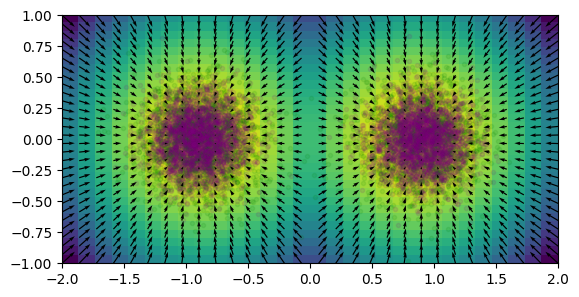

In [16]:
key, _ = jax.random.split(key)
samples = get_samples(key, 5000)

xs = jnp.linspace(-2, 2, num = 30)
ys = jnp.linspace(-1, 1, num = 30)
xx, yy = jnp.meshgrid(xs, ys)
coord = jnp.stack((xx, yy), axis = -1)

log_p = calc_log_p(coord)
score = calc_score(coord)

plt.scatter(x[:,0], x[:,1], color = "green", alpha = 0.1, marker = ".")
plt.scatter(samples[:,0], samples[:,1], color = "purple", alpha = 0.1, marker = ".")
plt.imshow(log_p, extent = [-2, 2, -1, 1])
plt.quiver(xx, yy, score[...,0],score[...,1])